In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from preprocess import process_cad_rads_labels, evaluate_performance, plot_confusion_matrix, compare_certainty

In [2]:
API = 'chatgpt'
# API = 'claude'
# API = 'gemini'

In [3]:
USE_COT = True
# USE_COT = False

# USE_CERTAINTY = True
USE_CERTAINTY = False

MAX_OUTPUT_LENGTH = 1000 if USE_COT else 50

In [4]:

if API == 'chatgpt':
    from openai import OpenAI
    api_key = 'YOUR_API_KEY'
    client = OpenAI(api_key=api_key)

elif API == "claude":
    import anthropic
    api_key = 'YOUR_API_KEY'
    client = anthropic.Anthropic(api_key=api_key)

elif API == "gemini":
    import google.generativeai as genai
    api_key = 'YOUR_API_KEY'
    genai.configure(api_key=api_key)

print(API)

chatgpt


In [5]:
VERSION = 'v4.5'

# data = pd.read_csv('sample_processed.csv')
# data = pd.read_csv('sample_processed_v2.2.csv')
# data = pd.read_csv('sample_processed_v2.3.csv')
# data = pd.read_csv('sample_processed_v3.0.csv')
data = pd.read_csv(f'sample_processed_{VERSION}.csv')

data.fillna(value='None', inplace=True)

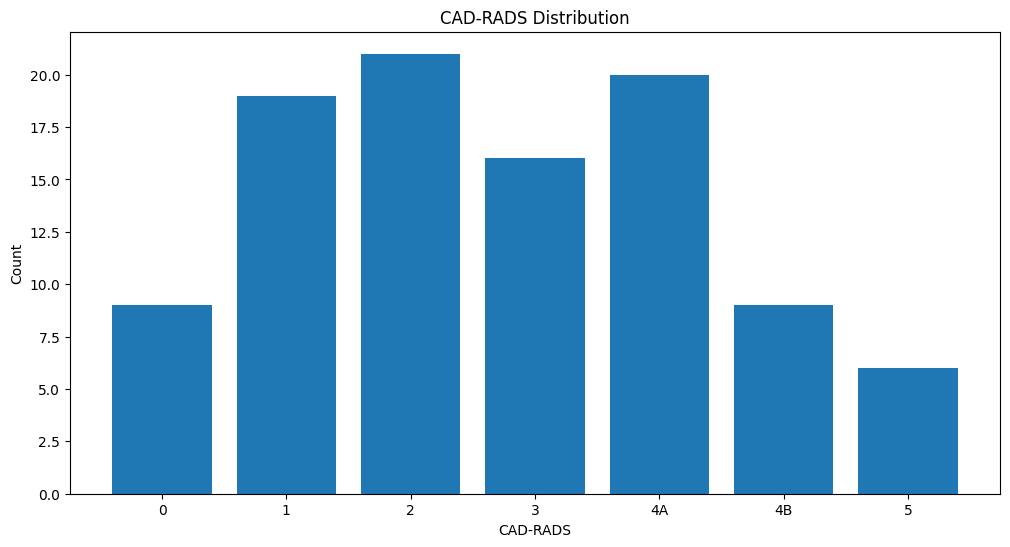

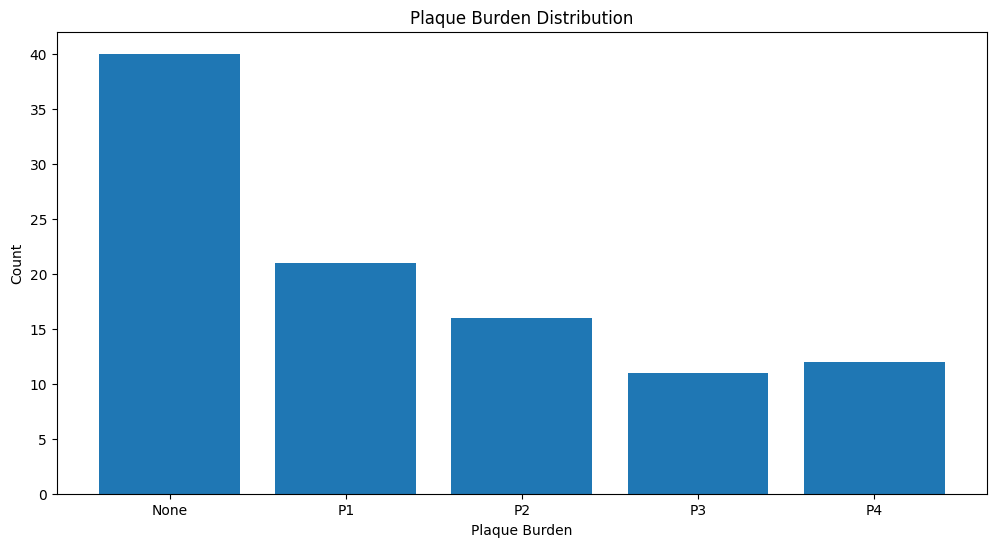

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# CAD-RADS 분포 그래프
plt.figure(figsize=(12, 6))
cad_rads_order = ['0', '1', '2', '3', '4A', '4B', '5']
cad_rads_counts = data['CAD-RADS'].value_counts().reindex(cad_rads_order).fillna(0)

plt.bar(cad_rads_counts.index, cad_rads_counts.values)
plt.title('CAD-RADS Distribution')
plt.xlabel('CAD-RADS')
plt.ylabel('Count')
plt.show()

# Plaque burden 분포 그래프
plt.figure(figsize=(12, 6))
plaque_burden_order = ['None', 'P1', 'P2', 'P3', 'P4']
plaque_burden_counts = data['Plaque Burden'].value_counts().reindex(plaque_burden_order).fillna(0)

plt.bar(plaque_burden_counts.index, plaque_burden_counts.values)
plt.title('Plaque Burden Distribution')
plt.xlabel('Plaque Burden')
plt.ylabel('Count')
plt.show()

In [7]:
if not USE_COT:
    # f = open("prompt_system.txt", 'r')
    # f = open("prompt_system_0612.txt", 'r')
    # f = open("prompt_system_0705.txt", 'r')
    # f = open("prompt_system_0828.txt", 'r')
    # f = open("prompt_system_0830.txt", 'r')
    f = open("prompt_system_1016.txt", 'r', encoding='utf-8')
elif USE_COT and not USE_CERTAINTY:
    # f = open("prompt_system_0828_cot.txt", 'r')
    # f = open("prompt_system_0829_cot.txt", 'r')
    # f = open("prompt_system_0830_cot.txt", 'r')
    # f = open("prompt_system_0913_cot.txt", 'r', encoding='utf-8')
    # f = open("prompt_system_0930_cot.txt", 'r', encoding='utf-8')
    f = open("prompt_system_1016_cot_edit.txt", 'r', encoding='utf-8')
elif USE_COT and USE_CERTAINTY:
    # f = open("prompt_system_0913_cot_certainty.txt", 'r', encoding='utf-8')
    # f = open("prompt_system_0930_cot_edit_certainty.txt", 'r', encoding='utf-8')
    # f = open("prompt_system_1014_cot_edit_certainty.txt", 'r', encoding='utf-8')
    f = open("prompt_system_1016_cot_edit_certainty.txt", 'r', encoding='utf-8')

prompt_sys = f.read()
f.close()
print(prompt_sys)


You need to extract the CAD-RADS, Plaque burden, and Modifier from a coronary artery CT report. Refer to the information below:

CAD-RADS
CAD-RADS is determined based on the most severe stenosis among various coronary branches:
- 0: 0%, Absence of CAD
- 1: 1-24%, Minimal non-obstructive CAD
- 2: 25-49%, Mild non-obstructive CAD (Mild stenosis)
- 3: 50-69%, Moderate stenosis
- 4A: 70-99% in a single or 2-vessel, Severe stenosis
- 4B: If the left main (LM) shows stenosis of 50% (moderate) or higher, or if 3-vessel(including LAD, LCx, RCA, OM, D, PDA) have stenosis of 70% (severe) or higher.
- 5: 100% Total coronary occlusion
 
Plaque Burden
Plaque Burden is determined by the overall amount of coronary plaque and Coronary artery calcium (CAC):
- None: 0
- P1: Mild, 1-100
- P2: Moderate, 101-300
- P3: Severe, 301-999
- P4: Extensive, >1000

Modifiers 
There are 6 modifiers that can be added to the CAD-RADS category. More than one modifiers can be applicable:
- N: If "Limited evaluation due

In [8]:
if not USE_COT:
    f = open("prompt_user_few.txt", 'r')

elif USE_COT and not USE_CERTAINTY:
    # f = open("prompt_user_few_cot.txt", 'r')
    f = open("prompt_user_few_cot_UpperEnd.txt", 'r')

elif USE_COT and USE_CERTAINTY:
    # f = open("prompt_user_few_cot_certainty.txt", 'r')
    f = open("prompt_user_few_cot_certainty_UpperEnd.txt", 'r')

prompt_user_few = f.read()
print(prompt_user_few)
f.close()


Extract the CAD-RADS, Plaque burden, and Modifier from a given coronary artery CT report like three examples below.
===
Example 1:

### Report:
s/p OPCAB; RSVG to LITA (Y), LITA to LAD, RSVG to OM1/OM2/PDA (seq).

RSVG to LITA (Y) patent.
LITA to LAD patent graft with good distal run-off.
RSVG to OM1 severe graft stenosis with faint distal run-off.
RSVG to OM2 Segmental occlusion - r/o graft regression.
RSVG to PDA (seq) patent graft with good distal run-off.

LM: <5% stenosis with calcified plaques.
pLCx: 50-60% stenosis with mixed plaques.
dLCx, OM1, OM2: multifocal severe stenosis to occlusion.
LV dilatation.
Diffuse atherosclerosis in thoracic aorta and its major branches without significant stenosis.

### Rationale: 
let's think step by step.

1. CAD-RADS:
- The report mentions "dLCx, OM1, OM2: multifocal severe stenosis to occlusion."
- Occlusion means 100% stenosis, which corresponds to CAD-RADS 5.
- Even though there are bypass grafts, some vessels still show occlusion.
- There

In [9]:
if API=='gemini':
    client = genai.GenerativeModel(
        # model_name="gemini-1.5-flash",
        model_name="gemini-1.5-pro",
        generation_config={
            "temperature": 0,
            "max_output_tokens": MAX_OUTPUT_LENGTH,
            "response_mime_type": "text/plain",
            },
        system_instruction=prompt_sys
        )

In [10]:
def get_response(API, client, prompt_sys, prompt): 
  if API == 'chatgpt':
    response = client.chat.completions.create(
      # model="gpt-4o",
      # model="gpt-4-turbo",
      # messages=[
      #   {
      #     "role": "system",
      #     "content": [
      #       {
      #         "type": "text",
      #         "text": prompt_sys,
      #       }
      #     ]
      #   },
      #   {
      #     "role": "user",
      #     "content": [
      #       {
      #         "type": "text",
      #         "text": prompt
      #       }
      #     ]
      #   }
      # ],
      # max_tokens=MAX_OUTPUT_LENGTH,
      # temperature=0,

      model="o1-mini",
      messages=[
        {
          "role": "user",
          "content": [
            {
              "type": "text",
              "text": prompt_sys,
            }
          ]
        },
        {
          "role": "user",
          "content": [
            {
              "type": "text",
              "text": prompt
            }
          ]
        }
      ],
      
      top_p=1,
      frequency_penalty=0,
      presence_penalty=0
    )

    return response.choices[0].message.content
  
  elif API == 'claude':
    response = client.messages.create(
      model="claude-3-5-sonnet-20240620",
      max_tokens=MAX_OUTPUT_LENGTH,
      temperature=0,
      system=prompt_sys,
      messages=[
          {
              "role": "user",
              "content": [
                  {
                      "type": "text",
                      "text": prompt
                  }
              ]
          }
      ]
    )
    return response.content[0].text

  elif API == 'gemini':
    chat_session = client.start_chat()
    response = chat_session.send_message(prompt)
    return response.text


In [11]:
if USE_COT:
    trigger = "Final Answer (CAD-RADS/Plaque Burden/Modifier):"
else:
    trigger = "CAD-RADS/Plaque Burden/Modifier: "

In [12]:
responses = []
labels = []
# for i in tqdm(range(3,6)):
for i in tqdm(range(len(data))):
    prompt = prompt_user_few + '\n' + data['Report'][i] #+ "\n\n### CAD-RADS/Plaque Burden/Modifier: "
    response = get_response(API, client, prompt_sys, prompt)

    if trigger in response:
        responses.append(response)
    else:
        print(f'Response {i} does not contain the final answer. Retrying.')
        print(response)
        new_response = get_response(API, client, prompt_sys, prompt + "\n\n### Rationale:\n" + response + "\n\n" + trigger)
        responses.append(response + "\n\n" + trigger + new_response)

  2%|▏         | 2/100 [00:13<11:31,  7.06s/it]

Response 2 does not contain the final answer. Retrying.
2/P3/N


 23%|██▎       | 23/100 [04:20<15:23, 11.99s/it]

Response 23 does not contain the final answer. Retrying.
4B/P4/N


 28%|██▊       | 28/100 [05:32<15:20, 12.78s/it]

Response 28 does not contain the final answer. Retrying.
4B/P2/S


 50%|█████     | 50/100 [10:12<11:00, 13.20s/it]

Response 50 does not contain the final answer. Retrying.
1/P1/


 51%|█████     | 51/100 [10:37<13:36, 16.67s/it]

Response 51 does not contain the final answer. Retrying.
2/P2/S


 71%|███████   | 71/100 [14:43<07:52, 16.28s/it]

Response 71 does not contain the final answer. Retrying.
3/P2/


 76%|███████▌  | 76/100 [15:39<04:21, 10.89s/it]

Response 76 does not contain the final answer. Retrying.
1/P1


 93%|█████████▎| 93/100 [19:12<01:21, 11.58s/it]

Response 93 does not contain the final answer. Retrying.
2/None/G,S


100%|██████████| 100/100 [20:45<00:00, 12.45s/it]


In [22]:
labels = [r.split(trigger)[-1].split('\n')[0] for r in responses]
labels = pd.DataFrame(labels)
responses = pd.DataFrame(responses)

AttributeError: 'int' object has no attribute 'split'

In [14]:
import re

def process_data(data):
    certainty_cadrads = []
    certainty_plaque = []
    processed_strings = []

    for item in data:
        parts = item.split('/')
        
        # CAD-RADS Certainty 추출
        cadrads_match = re.search(r'\((\d+)\)', parts[0])
        if cadrads_match:
            certainty_cadrads.append(int(cadrads_match.group(1)))
        
        # Plaque Certainty 추출
        plaque_match = re.search(r'\((\d+)\)', parts[1])
        if plaque_match:
            certainty_plaque.append(int(plaque_match.group(1)))
        
        # 괄호와 내용 제거
        processed_item = '/'.join([re.sub(r'\([^)]*\)', '', part).strip() for part in parts])
        processed_strings.append(processed_item)
    
    return certainty_cadrads, certainty_plaque, processed_strings

In [15]:
if USE_CERTAINTY:
    certainty_cadrads, certainty_plaque, processed_strings = process_data(list(labels[0]))
    labels = pd.DataFrame(processed_strings)

In [16]:
labels = process_cad_rads_labels(labels,0)

In [17]:
if USE_CERTAINTY:
    labels['certainty_cadrads'] = certainty_cadrads
    labels['certainty_plaque'] = certainty_plaque

In [18]:
# TAG = "CoT_edit_GPT4"
# TAG = "CoT_edit_certainty_UpperEnd"
# TAG = "CoT"
# TAG = "CoT_certainty_o1-mini"
# TAG = "GPT4"
# TAG = "CoT_GPT4"
# TAG = "o1-mini"
TAG = "CoT_o1-mini"
# TAG = ""

filename = f'result_1016_{API}_InterVal_{VERSION}_{TAG}.xlsx'
print(filename)
pd.concat([data, labels, responses], axis=1).to_excel(filename)

result_1016_chatgpt_InterVal_v4.5_CoT_o1-mini.xlsx


# GPT4

In [19]:
labels = data.iloc[:,4:]

# pred = pd.read_excel('result_0829_chatgpt_v4.4_CoT_x_after_answer_x_none.xlsx')
# pred = pd.read_excel('result_0930_chatgpt_v4.5_CoT.xlsx')
# pred = pd.read_excel('result_0930_chatgpt_v4.5_CoT_edit.xlsx')
# pred = pd.read_excel('result_0930_chatgpt_v4.5_CoT_edit_GPT4.xlsx')
# pred = pd.read_excel('result_1016_chatgpt_InterVal_v4.5_GPT4.xlsx')
# pred = pd.read_excel('result_1016_chatgpt_InterVal_v4.5_o1-mini.xlsx')
# pred = pd.read_excel('result_1016_chatgpt_InterVal_v4.5_CoT_GPT4.xlsx')
pred = pd.read_excel('result_1016_chatgpt_InterVal_v4.5_CoT_o1-mini.xlsx')
pred = pred.iloc[:,-9:-1]

# pred = pd.read_excel('result_0913_chatgpt_v4.5_CoT_certainty.xlsx')
# pred = pd.read_excel('result_0930_chatgpt_v4.5_CoT_edit_certainty.xlsx')
# pred = pd.read_excel('result_1014_chatgpt_InterVal_v4.5_CoT_edit_certainty_UpperEnd.xlsx')
# pred = pd.read_excel('result_1016_chatgpt_InterVal_v4.5_CoT_edit_certainty_UpperEnd.xlsx')
# pred = pd.read_excel('result_1016_chatgpt_InterVal_v4.5_CoT_certainty_o1-mini.xlsx')
# pred = pd.read_excel('result_1016_chatgpt_InterVal_v4.5_CoT_certainty_GPT4.xlsx')
# certainty = pred[['certainty_cadrads', 'certainty_plaque']]
# pred = pred.iloc[:,-11:-3]

# pred = pd.read_excel('result_1016_chatgpt_InterVal_v4.5_.xlsx')
# pred = pd.read_excel('result_1016_chatgpt_InterVal_v4.5_CoT.xlsx')
# pred = pred.iloc[:, -9:-1]

# 모든 컬럼 이름에서 '.1' 제거
pred.columns = pred.columns.str.replace('.1', '')
pred = pred[labels.iloc[:,:-1].columns]

C:\Users\User\AppData\Local\Temp\ipykernel_226592\629909387.py:27: FutureWarning: The default value of regex will change from True to False in a future version.
  pred.columns = pred.columns.str.replace('.1', '')


In [20]:
pred = pred.iloc[3:]
labels = labels.iloc[3:]

if USE_CERTAINTY:
    certainty = certainty.iloc[3:]

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


CAD-RADS Metrics:
Accuracy: 96.43%
F1 Score: 0.964


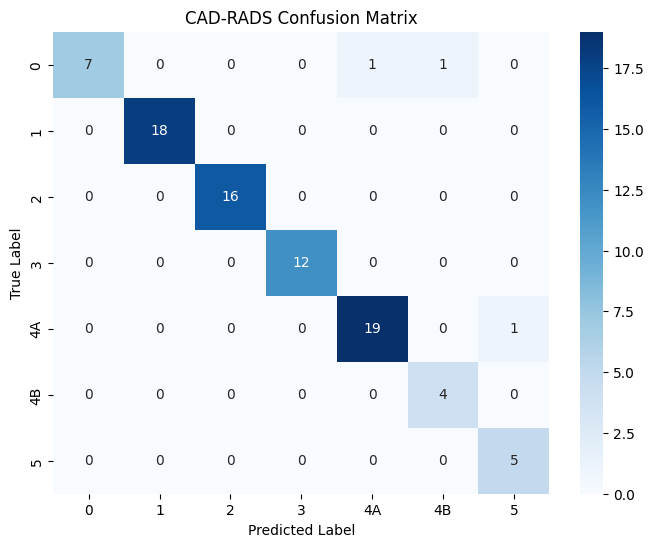

Plaque Burden Metrics:
Accuracy: 98.41%
F1 Score: 0.9834


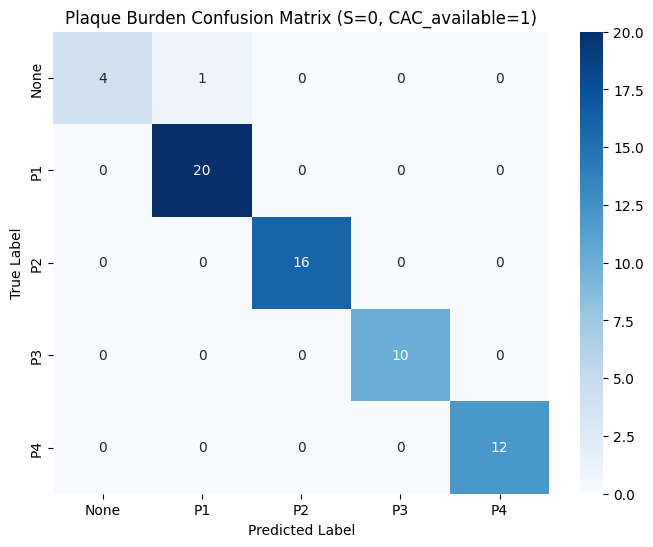

S Metrics:
Accuracy: 100.0%
F1 Score: 1.0


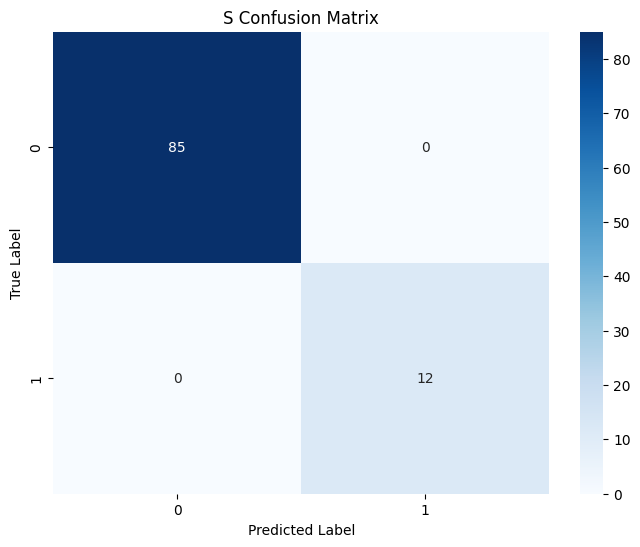

HRP Metrics:
Accuracy: 100.0%
F1 Score: 1.0


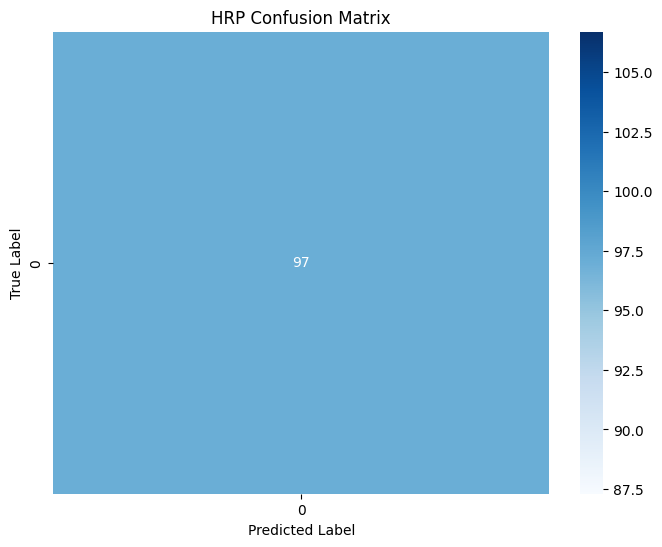

G Metrics:
Accuracy: 98.97%
F1 Score: 0.9894


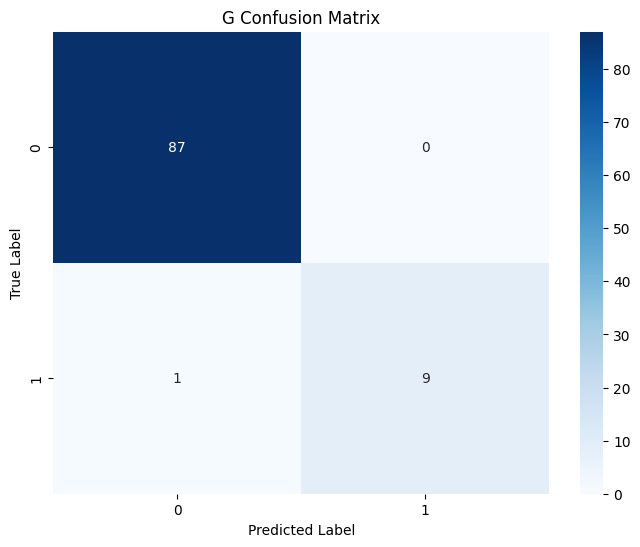

N Metrics:
Accuracy: 92.78%
F1 Score: 0.929


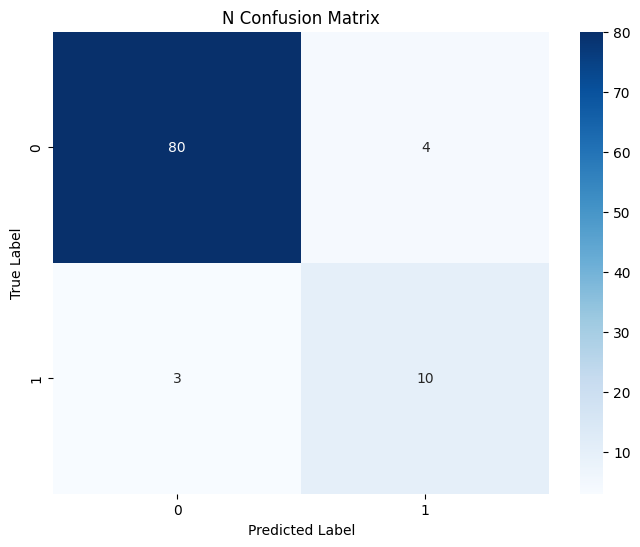

I Metrics:
Accuracy: 100.0%
F1 Score: 1.0


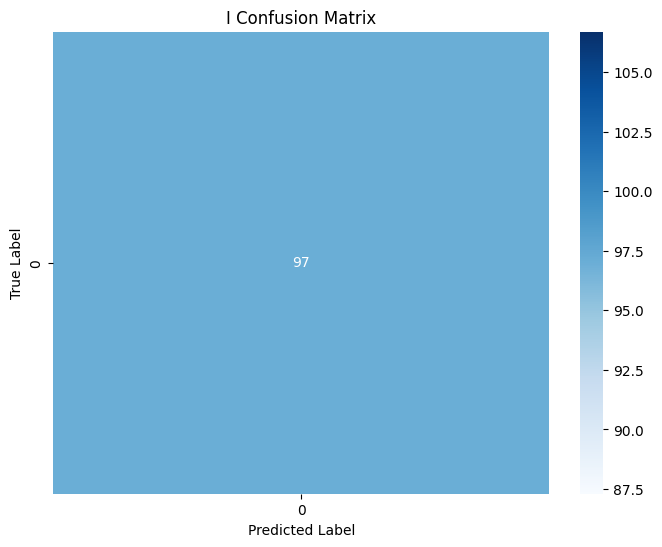

E Metrics:
Accuracy: 97.94%
F1 Score: 0.9844


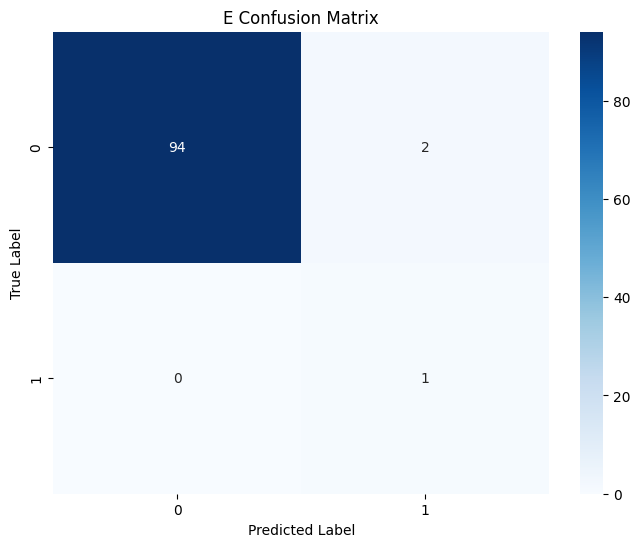

In [23]:
# 성능 평가 및 플롯 실행
performance_metrics = evaluate_performance(labels, pred)
for key, value in performance_metrics.items():
    print(f"{key} Metrics:")
    print(f"Accuracy: {round(value['Accuracy']*100,2)}%")
    print(f"F1 Score: {round(value['F1 Score'], 4)}")
    # print(f"Confusion Matrix:\n{value['Confusion Matrix']}\n")
    # 혼동 행렬 플롯
    if key in ['CAD-RADS', 'HRP', 'E', 'G', 'N', 'I', 'S']:
        class_labels = np.unique(np.concatenate((pred[key].dropna(), labels[key].dropna())))
        plot_confusion_matrix(value['Confusion Matrix'], class_labels, title=f'{key} Confusion Matrix')
    elif key == 'Plaque Burden':
        # S가 0이고 CAC_available이 1인 경우만 선택
        mask = (labels['S'] == 0) & (labels['CAC_available'] == 1)
        plaque_data = pred[key][mask].dropna()
        plaque_labels = labels[key][mask].dropna()
        class_labels = np.unique(np.concatenate((plaque_data, plaque_labels)))
        plot_confusion_matrix(value['Confusion Matrix'], class_labels, title=f'{key} Confusion Matrix (S=0, CAC_available=1)')

In [23]:
certainty_comparison = compare_certainty(labels, pred, certainty)

NameError: name 'certainty' is not defined

In [43]:
# 결과 출력
for category, values in certainty_comparison.items():
    print(f"\n{category}:")
    print(f"  Correct predictions:")
    print(f"    Average: {values['Avg Certainty (Correct)']:.4f}")
    print(f"    Std Dev: {values['Std Certainty (Correct)']:.4f}")
    print(f"  Incorrect predictions:")
    print(f"    Average: {values['Avg Certainty (Incorrect)']:.4f}")
    print(f"    Std Dev: {values['Std Certainty (Incorrect)']:.4f}")
    print(f"  Difference in averages: {values['Difference']:.4f}")
    print(f"  T-statistic: {values['t-statistic']:.4f}")
    print(f"  P-value: {values['p-value']:.4f}")
    print(f"  Statistical Significance: {'Significant' if values['p-value'] < 0.05 else 'Not Significant'}")


CAD-RADS:
  Correct predictions:
    Average: 9.8108
    Std Dev: 0.4277
  Incorrect predictions:
    Average: 9.5000
    Std Dev: 0.5270
  Difference in averages: 0.3108
  T-statistic: 2.0982
  P-value: 0.0390
  Statistical Significance: Significant

Plaque Burden:
  Correct predictions:
    Average: 10.0000
    Std Dev: 0.0000
  Incorrect predictions:
    Average: 10.0000
    Std Dev: 0.0000
  Difference in averages: 0.0000
  T-statistic: nan
  P-value: nan
  Statistical Significance: Not Significant


# Claude3.5 sonnet

In [30]:
labels = data.iloc[:,4:]

# pred = pd.read_excel('result_0814_claude_v4.2.xlsx')
# pred = pd.read_excel('result_0829_claude_v4.3_.xlsx')
# pred = pd.read_excel('result_0828_claude_v4.3_CoT.xlsx')
# pred = pred.iloc[:,-8:]

# pred = pd.read_excel('result_0829_claude_v4.3_CoT.xlsx')
# pred = pd.read_excel('result_0829_claude_v4.4_CoT.xlsx')
# pred = pd.read_excel('result_0829_claude_v4.4_CoT_x_after_answer.xlsx')
# pred = pd.read_excel('result_0829_claude_v4.4_CoT_x_after_answer_x_none.xlsx')
# pred = pd.read_excel('result_0913_claude_v4.4_CoT_x_after_answer_x_none.xlsx')
# pred = pd.read_excel('result_0930_claude_v4.5_CoT.xlsx')
# pred = pd.read_excel('result_0930_claude_v4.5_CoT_edit.xlsx')
# pred = pred.iloc[:,-9:-1]

# pred = pd.read_excel('result_0930_claude_v4.5_CoT_edit_certainty.xlsx')
pred = pd.read_excel('result_1014_claude_InterVal_v4.5_CoT_edit_certainty_UpperEnd.xlsx')
certainty = pred[['certainty_cadrads', 'certainty_plaque']]
pred = pred.iloc[:,-11:-3]

# 모든 컬럼 이름에서 '.1' 제거
pred.columns = pred.columns.str.replace('.1', '')
pred = pred[labels.iloc[:,:-1].columns]

C:\Users\User\AppData\Local\Temp\ipykernel_171632\3577993295.py:23: FutureWarning: The default value of regex will change from True to False in a future version.
  pred.columns = pred.columns.str.replace('.1', '')


CAD-RADS Metrics:
Accuracy: 95.88%
F1 Score: 0.9581


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


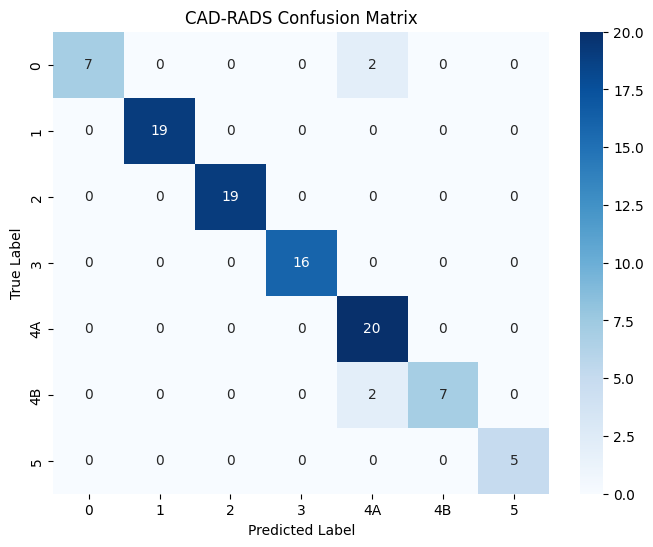

Plaque Burden Metrics:
Accuracy: 100.0%
F1 Score: 1.0


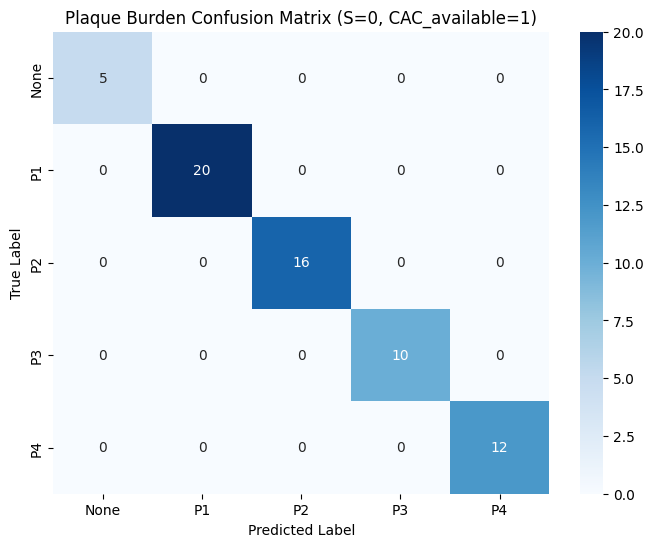

S Metrics:
Accuracy: 100.0%
F1 Score: 1.0


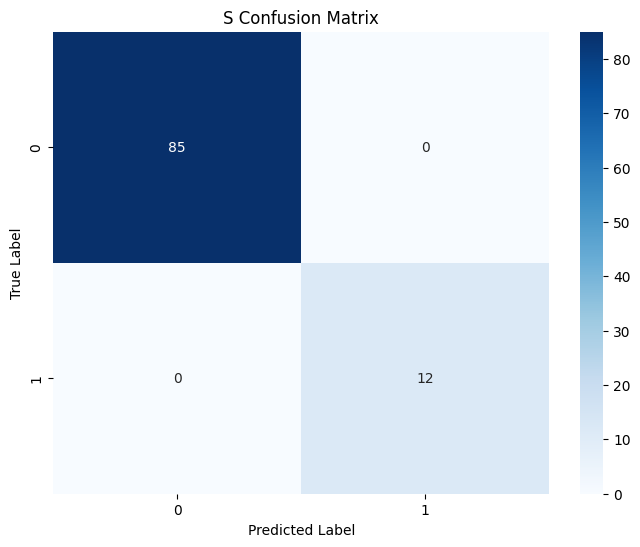

HRP Metrics:
Accuracy: 97.94%
F1 Score: 0.9896


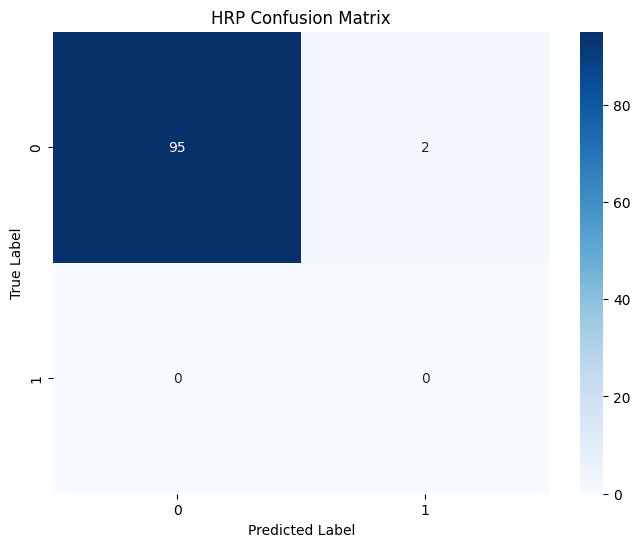

G Metrics:
Accuracy: 100.0%
F1 Score: 1.0


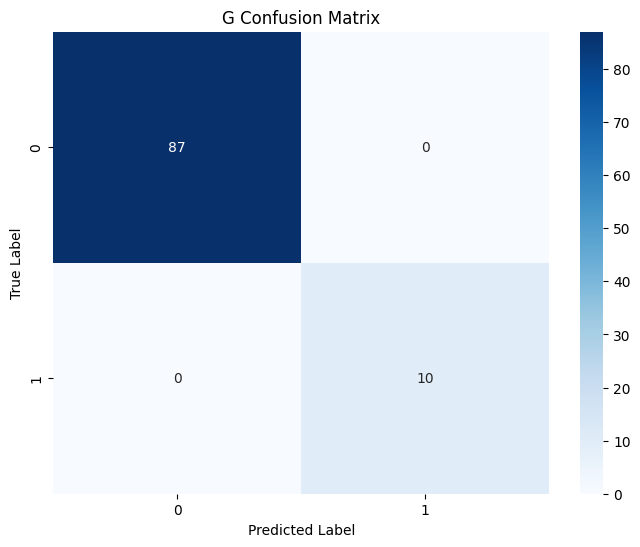

N Metrics:
Accuracy: 94.85%
F1 Score: 0.9518


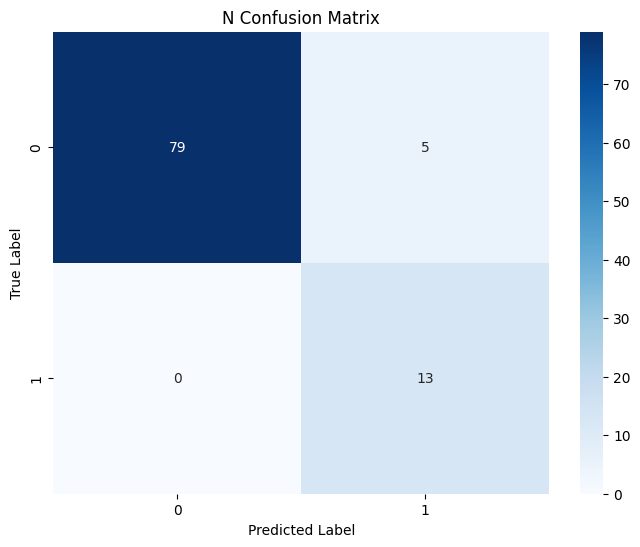

I Metrics:
Accuracy: 100.0%
F1 Score: 1.0


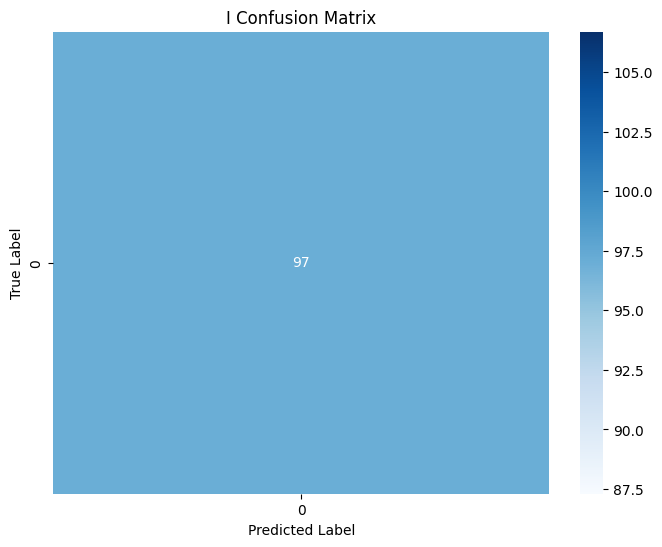

E Metrics:
Accuracy: 98.97%
F1 Score: 0.9914


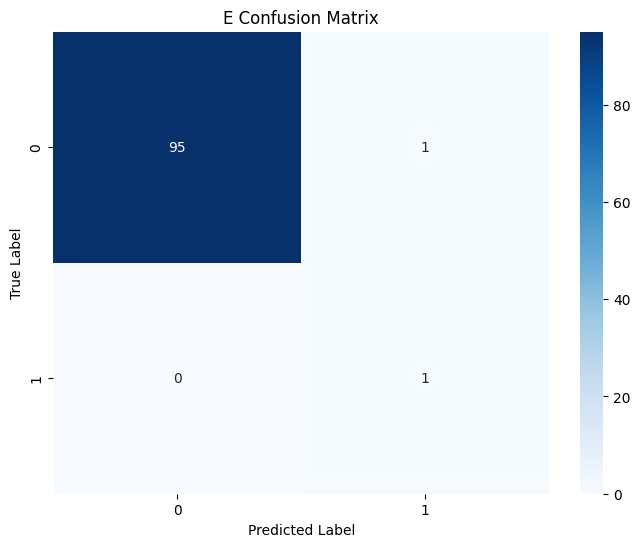

In [31]:
# 성능 평가 및 플롯 실행
performance_metrics = evaluate_performance(labels.iloc[3:], pred.iloc[3:])
for key, value in performance_metrics.items():
    print(f"{key} Metrics:")
    print(f"Accuracy: {round(value['Accuracy']*100,2)}%")
    print(f"F1 Score: {round(value['F1 Score'], 4)}")
    # print(f"Confusion Matrix:\n{value['Confusion Matrix']}\n")
    # 혼동 행렬 플롯
    if key in ['CAD-RADS', 'HRP', 'E', 'G', 'N', 'I', 'S']:
        class_labels = np.unique(np.concatenate((pred[key].dropna(), labels[key].dropna())))
        plot_confusion_matrix(value['Confusion Matrix'], class_labels, title=f'{key} Confusion Matrix')
    elif key == 'Plaque Burden':
        # S가 0이고 CAC_available이 1인 경우만 선택
        mask = (labels['S'].iloc[3:] == 0) & (labels['CAC_available'].iloc[3:] == 1)
        plaque_data = pred[key].iloc[3:][mask].dropna()
        plaque_labels = labels[key].iloc[3:][mask].dropna()
        class_labels = np.unique(np.concatenate((plaque_data, plaque_labels)))
        plot_confusion_matrix(value['Confusion Matrix'], class_labels, title=f'{key} Confusion Matrix (S=0, CAC_available=1)')

In [60]:
certainty_comparison = compare_certainty(labels, pred, certainty)

In [61]:
# 결과 출력
for category, values in certainty_comparison.items():
    print(f"\n{category}:")
    print(f"  Correct predictions:")
    print(f"    Average: {values['Avg Certainty (Correct)']:.4f}")
    print(f"    Std Dev: {values['Std Certainty (Correct)']:.4f}")
    print(f"  Incorrect predictions:")
    print(f"    Average: {values['Avg Certainty (Incorrect)']:.4f}")
    print(f"    Std Dev: {values['Std Certainty (Incorrect)']:.4f}")
    print(f"  Difference in averages: {values['Difference']:.4f}")
    print(f"  T-statistic: {values['t-statistic']:.4f}")
    print(f"  P-value: {values['p-value']:.4f}")
    print(f"  Statistical Significance: {'Significant' if values['p-value'] < 0.05 else 'Not Significant'}")


CAD-RADS:
  Correct predictions:
    Average: 8.9140
    Std Dev: 0.6537
  Incorrect predictions:
    Average: 8.2500
    Std Dev: 0.9574
  Difference in averages: 0.6640
  T-statistic: 1.9541
  P-value: 0.0536
  Statistical Significance: Not Significant

Plaque Burden:
  Correct predictions:
    Average: 9.9683
    Std Dev: 0.2520
  Incorrect predictions:
    Average: 8.2941
    Std Dev: 1.7326
  Difference in averages: 1.6741
  T-statistic: 7.5556
  P-value: 0.0000
  Statistical Significance: Significant


# Gemini

In [32]:
labels = data.iloc[:,4:]

# pred = pd.read_excel('result_0814_claude_v4.2.xlsx')
# pred = pd.read_excel('result_0829_claude_v4.3_.xlsx')
# pred = pd.read_excel('result_0828_claude_v4.3_CoT.xlsx')
# pred = pred.iloc[:,-8:]

# pred = pd.read_excel('result_0829_claude_v4.3_CoT.xlsx')
# pred = pd.read_excel('result_0829_claude_v4.4_CoT.xlsx')
# pred = pd.read_excel('result_0829_claude_v4.4_CoT_x_after_answer.xlsx')
# pred = pd.read_excel('result_0829_gemini_v4.4_CoT_x_after_answer_x_none.xlsx')
# pred = pd.read_excel('result_0913_gemini_v4.4_CoT_x_after_answer_x_none.xlsx')
# pred = pd.read_excel('result_0930_gemini_v4.5_CoT_edit.xlsx')
# pred = pred.iloc[:,-9:-1]

# pred = pd.read_excel('result_0930_gemini_v4.5_CoT_edit_certainty.xlsx')
pred = pd.read_excel('result_1014_gemini_InterVal_v4.5_CoT_edit_certainty_UpperEnd.xlsx')
certainty = pred[['certainty_cadrads', 'certainty_plaque']]
pred = pred.iloc[:,-11:-3]

# 모든 컬럼 이름에서 '.1' 제거
pred.columns = pred.columns.str.replace('.1', '')
pred = pred[labels.iloc[:,:-1].columns]
pred.loc[pred['CAD-RADS']=='4', 'CAD-RADS']='4A'

C:\Users\User\AppData\Local\Temp\ipykernel_171632\1706678154.py:22: FutureWarning: The default value of regex will change from True to False in a future version.
  pred.columns = pred.columns.str.replace('.1', '')


CAD-RADS Metrics:
Accuracy: 86.6%
F1 Score: 0.8597


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


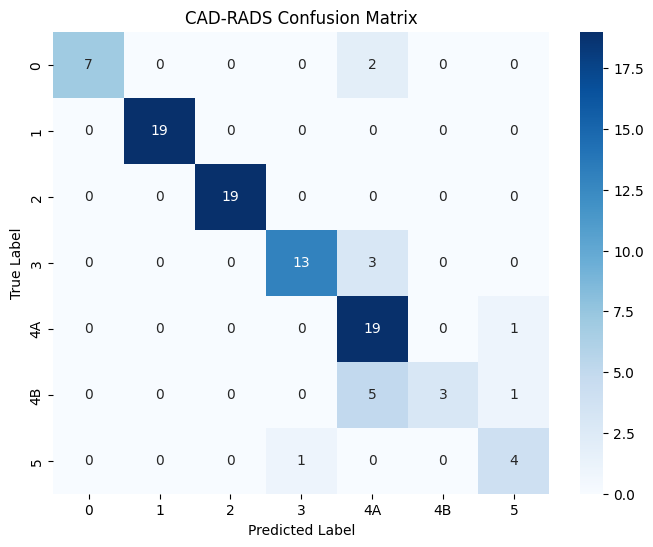

Plaque Burden Metrics:
Accuracy: 95.24%
F1 Score: 0.9524


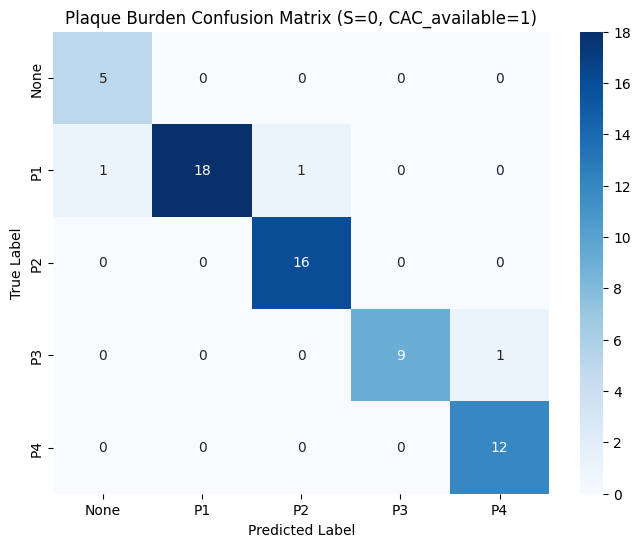

S Metrics:
Accuracy: 98.97%
F1 Score: 0.9895


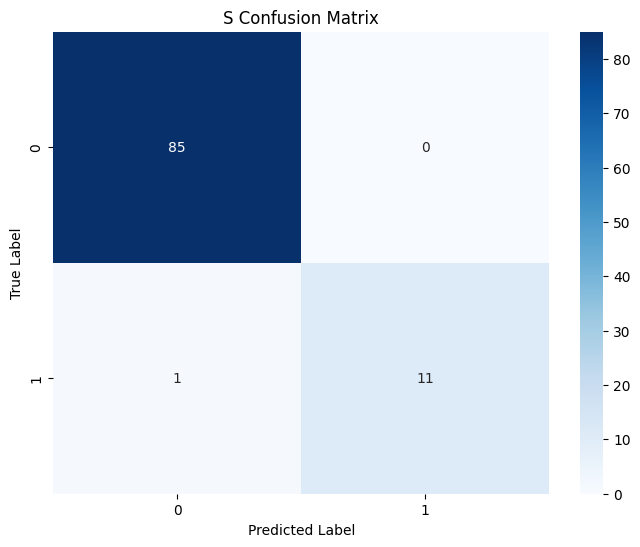

HRP Metrics:
Accuracy: 97.94%
F1 Score: 0.9896


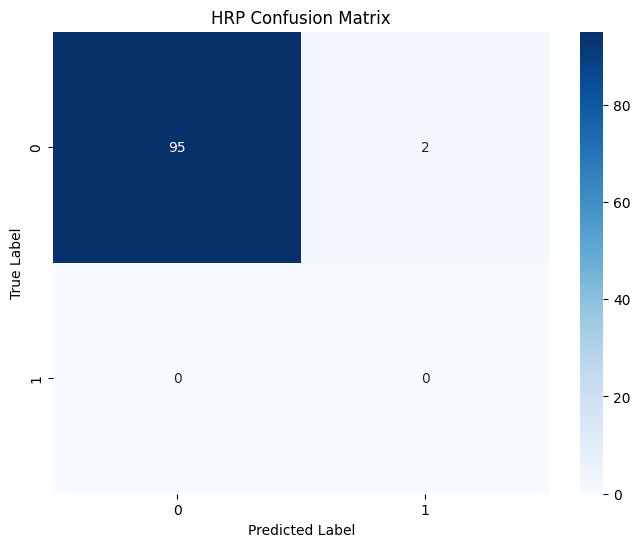

G Metrics:
Accuracy: 100.0%
F1 Score: 1.0


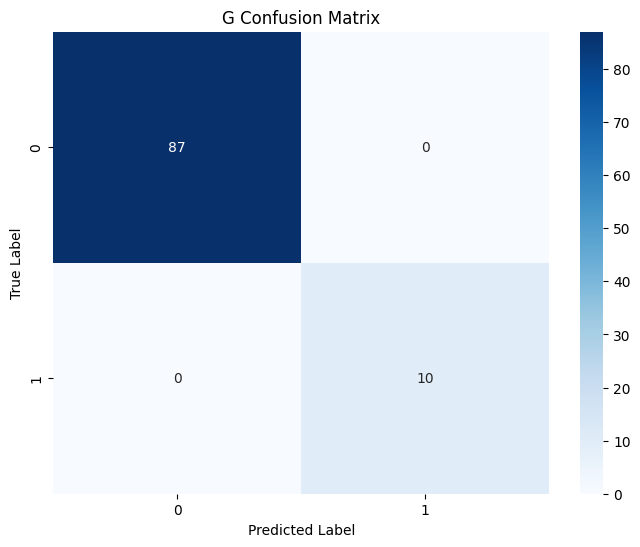

N Metrics:
Accuracy: 94.85%
F1 Score: 0.9493


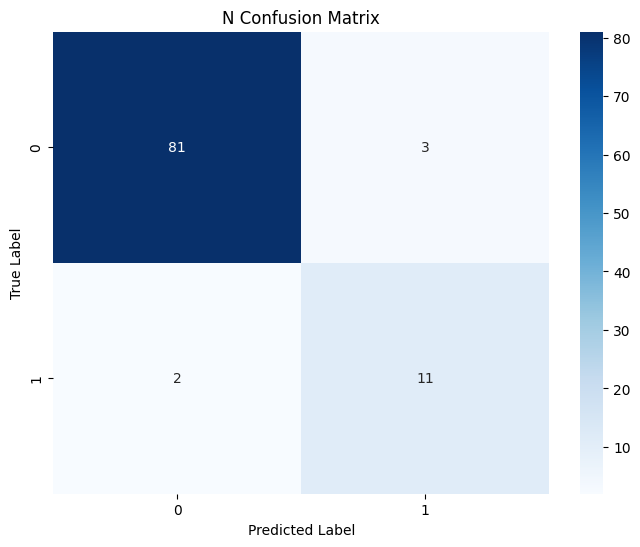

I Metrics:
Accuracy: 100.0%
F1 Score: 1.0


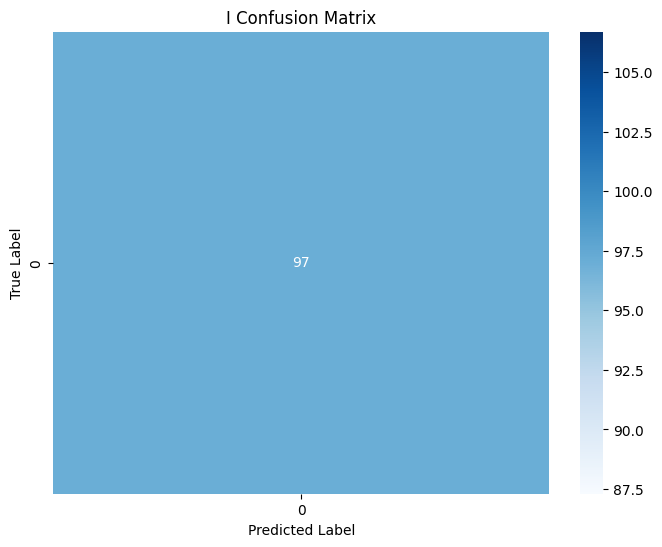

E Metrics:
Accuracy: 97.94%
F1 Score: 0.9844


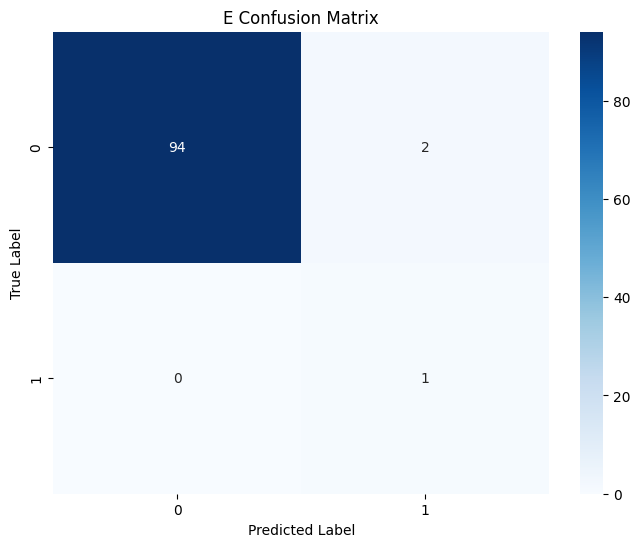

In [33]:
# 성능 평가 및 플롯 실행
performance_metrics = evaluate_performance(labels.iloc[3:], pred.iloc[3:])
for key, value in performance_metrics.items():
    print(f"{key} Metrics:")
    print(f"Accuracy: {round(value['Accuracy']*100,2)}%")
    print(f"F1 Score: {round(value['F1 Score'], 4)}")
    # print(f"Confusion Matrix:\n{value['Confusion Matrix']}\n")
    # 혼동 행렬 플롯
    if key in ['CAD-RADS', 'HRP', 'E', 'G', 'N', 'I', 'S']:
        class_labels = np.unique(np.concatenate((pred[key].dropna(), labels[key].dropna())))
        plot_confusion_matrix(value['Confusion Matrix'], class_labels, title=f'{key} Confusion Matrix')
    elif key == 'Plaque Burden':
        # S가 0이고 CAC_available이 1인 경우만 선택
        mask = (labels['S'].iloc[3:] == 0) & (labels['CAC_available'].iloc[3:] == 1)
        plaque_data = pred[key].iloc[3:][mask].dropna()
        plaque_labels = labels[key].iloc[3:][mask].dropna()
        class_labels = np.unique(np.concatenate((plaque_data, plaque_labels)))
        plot_confusion_matrix(value['Confusion Matrix'], class_labels, title=f'{key} Confusion Matrix (S=0, CAC_available=1)')

In [51]:
certainty_comparison = compare_certainty(labels, pred, certainty)

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [52]:
# 결과 출력
for category, values in certainty_comparison.items():
    print(f"\n{category}:")
    print(f"  Correct predictions:")
    print(f"    Average: {values['Avg Certainty (Correct)']:.4f}")
    print(f"    Std Dev: {values['Std Certainty (Correct)']:.4f}")
    print(f"  Incorrect predictions:")
    print(f"    Average: {values['Avg Certainty (Incorrect)']:.4f}")
    print(f"    Std Dev: {values['Std Certainty (Incorrect)']:.4f}")
    print(f"  Difference in averages: {values['Difference']:.4f}")
    print(f"  T-statistic: {values['t-statistic']:.4f}")
    print(f"  P-value: {values['p-value']:.4f}")
    print(f"  Statistical Significance: {'Significant' if values['p-value'] < 0.05 else 'Not Significant'}")


CAD-RADS:
  Correct predictions:
    Average: 9.0119
    Std Dev: 0.7838
  Incorrect predictions:
    Average: 8.8462
    Std Dev: 0.8006
  Difference in averages: 0.1658
  T-statistic: 0.7076
  P-value: 0.4809
  Statistical Significance: Not Significant

Plaque Burden:
  Correct predictions:
    Average: 10.0000
    Std Dev: 0.0000
  Incorrect predictions:
    Average: 8.4054
    Std Dev: 1.7553
  Difference in averages: 1.5946
  T-statistic: 7.0599
  P-value: 0.0000
  Statistical Significance: Significant
